# Homework 2

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.integrate import quad, dblquad, tplquad
from scipy.stats import multivariate_normal
import itertools

## Task 1 - Probability mass in high dimensions

### Part 1 - Monte carlo

In [2]:
def mc_mass(d, n_sim=1000000, breaks=np.linspace(0,5,51), seed=1234):
    """
    Use monte carlo methods to approximate the probability mass of
    multivariate normal distributions within d-dimensional shells.
    
    Arguments:
    d (int): number of dimension
    n_sim (int): number of samples to draw from the multivariate normal
    breaks (array): cut points to define shells
    seed (int): random seed used by the random number generator
    
    Returns:
    a tuple containing an array of the average radius for each shell
    and an array of the probability masses
    """
    np.random.seed(seed)
    mean = np.repeat(0,d)
    cov = np.identity(d)
    pts = np.random.multivariate_normal(mean, cov, n_sim)
    
    norm = np.linalg.norm(pts, axis = 1) # L2-norm
    fraction = np.histogram(norm, bins = breaks)[0]/n_sim
    avg_radius = (breaks[:-1] + breaks[1:]) / 2 # average of two cut points
    return (avg_radius, fraction)


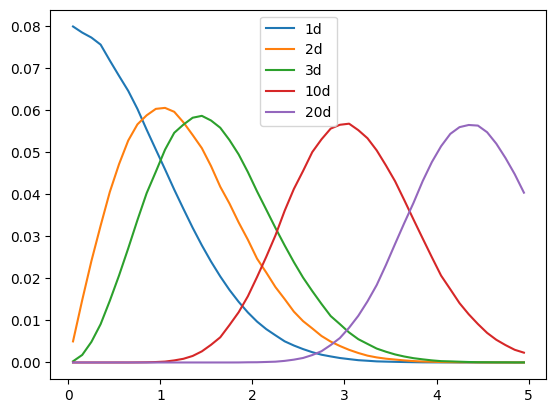

In [3]:
plt.cla()
plt.plot(*mc_mass(1), label="1d")
plt.plot(*mc_mass(2), label="2d")
plt.plot(*mc_mass(3), label="3d")
plt.plot(*mc_mass(10), label="10d")
plt.plot(*mc_mass(20), label="20d")
plt.legend()
plt.show()

*From the density plots, when the dimension is one, the maximum probability mass occurs at the origin, which is consistent to our intuition. However, as the dimensionality increases, the probability mass is small at the origin. It first increases to the maximum as the distance from the origin increases, then it decreases to zero as the distance goes to infinity. The probability mass of distributions tends to concentrate in surfaces that is far from the origin, which is counter to our intuition.*

### Part 2 - Numerical integration

In [4]:
def ni_mass(d, breaks=np.linspace(0,5,51)):
    """
    Use numerical integration to analytically calculate the probability mass of
    multivariate normal distributions within d-dimensional shells.
    
    Arguments:
    d (int): number of dimension
    breaks (array): cut points to define shells
    
    Returns:
    a tuple containing an array of the average radius for each shell
    and an array of the probability masses
    """
    mean = np.repeat(0,d)
    cov = np.identity(d)
    length = len(breaks)
    volume = np.zeros(length)
    
    # multivariate normal density function is symmetric
    # save much time than original integration
    if d in np.array([1,2,3]):
        for i in range(length):
            r = breaks[i]
            if d == 1:
                volume[i] = quad(lambda x: multivariate_normal.pdf(x, mean, cov), 0, r)[0] * (2**d)
            elif d == 2:
                volume[i] = dblquad(lambda y,x: multivariate_normal.pdf([x,y], mean, cov),
                                    a = 0, b = r, gfun = 0, hfun = lambda x: np.sqrt(r**2-x**2))[0] * (2**d)
            elif d == 3:
                volume[i] = tplquad(lambda z,y,x: multivariate_normal.pdf([x,y,z], mean, cov),
                                    a = 0, b = r, gfun = 0, hfun = lambda x: np.sqrt(r**2-x**2),
                                    qfun = 0, rfun = lambda x,y: np.sqrt(r**2-x**2-y**2))[0] * (2**d)
        
        diff = volume[1:] - volume[:-1] # difference in mass between two spheres
        avg_radius = (breaks[:-1] + breaks[1:]) / 2 # average of two cut points
        return (avg_radius, diff)
    
    else:
        print("currently only support d is 1,2,3")


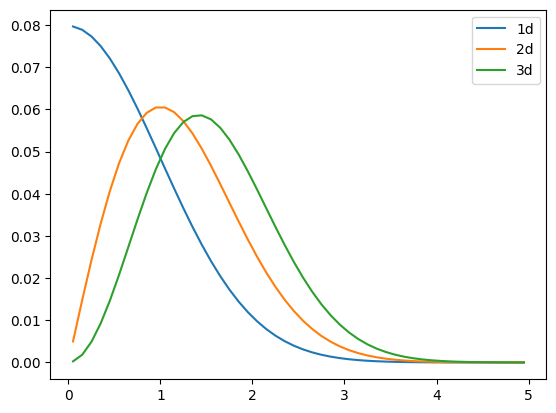

In [5]:
m1 = ni_mass(1)
m2 = ni_mass(2)
m3 = ni_mass(3, np.linspace(0,5,51)) # free to reduce the number of cut points to save time
plt.cla()
plt.plot(*m1, label="1d")
plt.plot(*m2, label="2d")
plt.plot(*m3, label="3d")
plt.legend()
plt.show()

*Results from Part 2 are very similar to Part 1. For one dimension case, the maximum probability mass occurs at the origin. Although we only implement the case up to three dimensions given the implementation inefficiency, the pattern still suggests that as the dimensionality increases, the probability mass tends to concentrate in surfaces that is far from the origin, which is counter to our intuition. In other words, it first increases to the maximum as the distance from the origin increases, then it decreases to zero as the distance goes to infinity.*

### Part 3 


*In summary, the concentration of probability mass for multivariate normal distributions is far from the origin. It first increases to the maximum as the distance from the origin increases, then it decreases to zero as the distance goes to infinity. Specifically, the larger the dimension, the farther the maximum probability mass appear to occur.*

---

## Task 2 - Pandas Practice

### Part 1 - Fisheries data

In [14]:
fisheries  = pd.read_csv("data/fisheries.csv")
continents = pd.read_csv("data/continents.csv")

In [15]:
fisheries["country"][~ fisheries["country"].isin(continents["country"])] # check which countries are not included in continents df

12    Democratic Republic of the Congo
24                           Hong Kong
46                             Myanmar
Name: country, dtype: object

In [16]:
df = pd.merge(continents,fisheries,how = "right",on = 'country')
df

,country,continent,capture,aquaculture,total
0,Angola,Africa,486490,655,487145
1,Argentina,Americas,755226,3673,758899
2,Australia,Oceania,174629,96847,271476
3,Bangladesh,Asia,1674770,2203554,3878324
4,Brazil,Americas,705000,581230,1286230
...,...,...,...,...,...
77,United States,Americas,4931017,444369,5375386
78,Venezuela,Americas,284175,25998,310173
79,Vietnam,Asia,2785940,3634531,6420471
80,Yemen,Asia,154450,0,154450


In [17]:
df.loc[df['country'] == 'Democratic Republic of the Congo','continent'] = 'Africa'
df.loc[df['country'] == 'Hong Kong','continent'] = 'Asia'
df.loc[df['country'] == 'Myanmar','continent'] = 'Asia'

In [18]:
df

,country,continent,capture,aquaculture,total
0,Angola,Africa,486490,655,487145
1,Argentina,Americas,755226,3673,758899
2,Australia,Oceania,174629,96847,271476
3,Bangladesh,Asia,1674770,2203554,3878324
4,Brazil,Americas,705000,581230,1286230
...,...,...,...,...,...
77,United States,Americas,4931017,444369,5375386
78,Venezuela,Americas,284175,25998,310173
79,Vietnam,Asia,2785940,3634531,6420471
80,Yemen,Asia,154450,0,154450


In [19]:
df1 = df.groupby("continent").sum(numeric_only=True)
df1

,capture,aquaculture,total
continent,,,
Africa,8413896,1979649,10393545
Americas,15935116,3184535,19119651
Asia,49563506,101073897,150637403
Europe,13682903,2788636,16471539
Oceania,1081487,215715,1297202


In [20]:
df1 = df1.div(df1.sum(axis=0), axis=1) 
# calculate proportion of capture, aquaculture, and total fisheries production by continent
df1 = df1.style.format({
    
    'capture': '{:,.2%}'.format,
    'aquaculture': '{:,.2%}'.format,
    'total': '{:,.2%}'.format
})
# round up the proportions

In [21]:
df1

,capture,aquaculture,total
continent,,,
Africa,9.49%,1.81%,5.25%
Americas,17.97%,2.92%,9.66%
Asia,55.89%,92.52%,76.11%
Europe,15.43%,2.55%,8.32%
Oceania,1.22%,0.20%,0.66%


### Part 2 - WHO Tuberculosis data

In [2]:
who = pd.read_csv("data/TB_notifications_2022-02-06.csv")

In [23]:
def filter_columns(dataframe, column_prefix, exclude_terms):
    columns = dataframe.columns[dataframe.columns.str.contains(column_prefix)]
    for term in exclude_terms:
        columns = columns[~columns.str.contains(term)]
    return columns



In [26]:
melt_ep = filter_columns(who, "new_ep", ["014", "m15plus", "f15plus"])
melt_sn = filter_columns(who, "new_sn", ["014", "m15plus", "f15plus"])
melt_sp = filter_columns(who, "new_sp", ["014", "m15plus", "f15plus"])
melt_rel = filter_columns(who, "newrel", ["014", "m59", "m1519", "m2024", "f59", "f1519", "f2024", "m15plus", "f15plus"])


In [27]:
#columns needed list
keep_cols = ['country', 'g_whoregion', 'year']
melt_cols = list(itertools.chain(melt_ep[1:],melt_sn[1:],melt_sp[1:],melt_rel[:22]))
#wide to long format based on columns needed
new_df_long = who.melt(id_vars = keep_cols, value_vars= melt_cols)

#eliminate na yield clean dataset
new_df_long_clean = new_df_long.dropna(subset = ['value'])
new_df_long_clean


,country,g_whoregion,year,variable,value
1303,Burkina Faso,AFR,2012,new_ep_m04,0.0
2462,Dominican Republic,AMR,2012,new_ep_m04,0.0
4635,Madagascar,AFR,2012,new_ep_m04,0.0
5993,Pakistan,EMR,2012,new_ep_m04,0.0
6936,Senegal,AFR,2012,new_ep_m04,0.0
...,...,...,...,...,...
720915,Senegal,AFR,2017,newrel_sexunkageunk,0.0
720916,Senegal,AFR,2018,newrel_sexunkageunk,0.0
721424,Sudan,EMR,2013,newrel_sexunkageunk,1713.0
721427,Sudan,EMR,2016,newrel_sexunkageunk,0.0


In [28]:
#new column of variables
#age group
new_df_long_clean["age_group"] = new_df_long_clean['variable'].apply(
    lambda x: "0-4" if (isinstance(x, str) and "04" in x) else 
                "5-14" if (isinstance(x, str) and "514" in x) else
              "15-24" if (isinstance(x, str) and "1524" in x) else
              "25-34" if (isinstance(x, str) and "2534" in x) else
              "35-44" if (isinstance(x, str) and "3544" in x) else
              "45-54" if (isinstance(x, str) and "4554" in x) else
              "55-64" if (isinstance(x, str) and "5564" in x) else
              "65+" if (isinstance(x, str) and "65" in x) else 
              "15+(specific in sex unknown cat)" if (isinstance(x, str) and "15plus" in x) else "Unkown")

print(new_df_long_clean['age_group'].value_counts())

#diagnosis method
new_df_long_clean["diagnostic_method"] = new_df_long_clean['variable'].apply(
    lambda x: "sn" if (isinstance(x, str) and "_sn_" in x) else 
              "sp" if (isinstance(x, str) and "_sp_" in x) else
              "rel" if (isinstance(x, str) and "newrel" in x) else
              "ep" if (isinstance(x, str) and "_ep_" in x) else "why there is empty")

print(new_df_long_clean['diagnostic_method'].value_counts())

#gender
new_df_long_clean["gender"] = new_df_long_clean['variable'].apply(
    lambda x: "Female" if (isinstance(x, str) and "_f" in x) else 
              "Male" if (isinstance(x, str) and "_m" in x) else
              "Unknown" if (isinstance(x, str) and "_sexunk" in x) else "why there is empty")

print(new_df_long_clean['gender'].value_counts())

#change variable name value to new cases
new_df_long_clean = new_df_long_clean.rename(columns={'value': 'new_cases'})
print(new_df_long_clean)


35-44                               13594
45-54                               13593
15-24                               13579
25-34                               13570
55-64                               13567
65+                                 13556
5-14                                 9045
0-4                                  8085
Unkown                               7716
15+(specific in sex unknown cat)       94
Name: age_group, dtype: int64
sp     44557
rel    27516
sn     17648
ep     16678
Name: diagnostic_method, dtype: int64
Female     53447
Male       52683
Unknown      269
Name: gender, dtype: int64
                   country g_whoregion  year             variable  new_cases  \
1303          Burkina Faso         AFR  2012           new_ep_m04        0.0   
2462    Dominican Republic         AMR  2012           new_ep_m04        0.0   
4635            Madagascar         AFR  2012           new_ep_m04        0.0   
5993              Pakistan         EMR  2012           new_ep_

/tmp/ipykernel_513213/1181808301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_long_clean["age_group"] = new_df_long_clean['variable'].apply(
/tmp/ipykernel_513213/1181808301.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_long_clean["diagnostic_method"] = new_df_long_clean['variable'].apply(
/tmp/ipykernel_513213/1181808301.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 